In [50]:
import numpy as np
import gzip
import os

# 指定本地文件路径
data_dir = "..\\assets\\MNIST\\raw"
filenames = ['train-images-idx3-ubyte.gz', 'train-labels-idx1-ubyte.gz',
             't10k-images-idx3-ubyte.gz', 't10k-labels-idx1-ubyte.gz']
data = []

for filename in filenames:
    filepath = os.path.join(data_dir, filename)
    print("Loading", filepath)
    with gzip.open(filepath, 'rb') as f:
        if 'labels' in filename:
            # 读取标签数据，偏移量为8字节
            data.append(np.frombuffer(f.read(), np.uint8, offset=8))
        else:
            # 读取图像数据，偏移量为16字节，并转换为 (num_samples, 28*28)
            data.append(np.frombuffer(f.read(), np.uint8, offset=16).reshape(-1, 28*28))

# 分割训练和测试数据
X_train, y_train, X_test, y_test = data

# 归一化像素值到 [0,1] 之间
X_train = X_train.astype(np.float32) / 255.0
X_test = X_test.astype(np.float32) / 255.0

# 转换标签为整数类型
y_train = y_train.astype(np.int64)
y_test = y_test.astype(np.int64)

print("Data loaded successfully!")

Loading ..\assets\MNIST\raw\train-images-idx3-ubyte.gz
Loading ..\assets\MNIST\raw\train-labels-idx1-ubyte.gz
Loading ..\assets\MNIST\raw\t10k-images-idx3-ubyte.gz
Loading ..\assets\MNIST\raw\t10k-labels-idx1-ubyte.gz
Data loaded successfully!


In [51]:
import matplotlib.pyplot as plt
def show_images(images, labels):
    """
    Display a set of images and their labels using matplotlib.
    The first column of `images` should contain the image indices,
    and the second column should contain the flattened image pixels
    reshaped into 28x28 arrays.
    """
    import matplotlib.pyplot as plt

    # Reshape the flattened image pixels to 28x28
    pixels = images.reshape(-1, 28, 28)
    num_images = len(images)

    # Create subplots
    fig, axs = plt.subplots(ncols=num_images, nrows=1, figsize=(10, 3 * num_images))

    # If only one image, axs is not a list, wrap it
    if num_images == 1:
        axs = [axs]

    # Display images
    for i in range(num_images):
        axs[i].imshow(pixels[i], cmap="gray")
        axs[i].set_title("Label: {}".format(labels[i]))
        axs[i].set_xticks([])
        axs[i].set_yticks([])
        axs[i].set_xlabel("Index: {}".format(i))

    fig.subplots_adjust(hspace=0.5)
    plt.show()


In [52]:
import torch.nn as nn
import torch
import torch.optim as optim
import torch.nn.functional as F

In [53]:
# 手写数字分类模型
class MLP(nn.Module):
    def __init__(self):
        super().__init__()

        self.fc1 = nn.Linear(28*28, 128)
        self.fc2 = nn.Linear(128, 10)
        

    def forward(self, x):
        Z1 = F.relu(self.fc1(x))
        A1 = torch.sigmoid(Z1)
        Z2 = self.fc2(A1)
        # A2 = F.softmax(Z2, dim=1)
        return Z2

In [54]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

model = MLP().to(device)
model.load_state_dict(torch.load("mlp_mnist.pth"))
model.eval()  # 切换为评估模式

for param in model.parameters():
    param.requires_grad = False  # 冻结所有参数

Using device: cuda


C:\Users\zhang\AppData\Local\Temp\ipykernel_26276\3538552559.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("mlp_mnist.pth"))


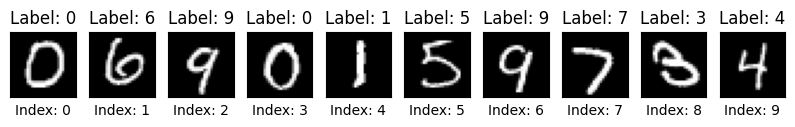

In [55]:
# 可视化模型预测结果
model.eval()
# X_test = torch.from_numpy(X_test).to(device)
# y_test = torch.from_numpy(y_test).to(device)
y_pred = model(torch.from_numpy(X_test).to(device))
y_pred = torch.argmax(y_pred, dim=1)
show_images(X_test[10:20], y_pred.cpu().numpy()[10:20])

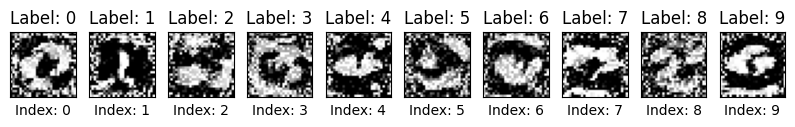

每个对抗图像的预测结果及置信度：
Image 0: Predicted = 0, Confidence = 0.9996
Image 1: Predicted = 1, Confidence = 0.9986
Image 2: Predicted = 2, Confidence = 0.9995
Image 3: Predicted = 3, Confidence = 0.9998
Image 4: Predicted = 4, Confidence = 0.9995
Image 5: Predicted = 5, Confidence = 0.9993
Image 6: Predicted = 6, Confidence = 0.9995
Image 7: Predicted = 7, Confidence = 0.9995
Image 8: Predicted = 8, Confidence = 0.9994
Image 9: Predicted = 9, Confidence = 0.9977


In [64]:
import torch
import torch.nn.functional as F
import numpy as np

model.eval()
adv_images = []  # 直接存 tensor
criterion = nn.CrossEntropyLoss()

# 对每个目标类别 0-9 生成一个对抗样本
for target in range(10):
    target_label = torch.tensor([target], dtype=torch.long, device=device)
    x_adv = torch.randn((1, 28*28), device=device, requires_grad=True)

    optimizer = torch.optim.Adam([x_adv], lr=0.1)

    for i in range(50):
        optimizer.zero_grad()
        output = model(x_adv)
        loss = criterion(output, target_label)
        loss.backward()
        optimizer.step()
        x_adv.data.clamp_(0, 1)

    # 保留优化后的 tensor（不转 numpy！）
    adv_images.append(x_adv.detach().clone())  # 必须 clone！

# 拼接成 batch tensor
adv_input_tensor = torch.cat(adv_images, dim=0)  # shape: (10, 784)

# 推理并计算 softmax 置信度
output = model(adv_input_tensor)
probs = F.softmax(output, dim=1)
adv_preds = torch.argmax(probs, dim=1).cpu().numpy()
confidences = probs[range(10), adv_preds].detach().cpu().numpy()

# 转为 numpy 格式用于可视化
adv_images_np = adv_input_tensor.cpu().numpy().reshape(-1, 28, 28)

# 可视化
show_images(adv_images_np, adv_preds)

# 输出置信度
print("每个对抗图像的预测结果及置信度：")
for i in range(10):
    print(f"Image {i}: Predicted = {adv_preds[i]}, Confidence = {confidences[i]:.4f}")
